In [8]:
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag
from nltk import PorterStemmer
from nltk.corpus import stopwords

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds as SVDS
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE


from sklearn.metrics.pairwise import distance_metrics 
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

import re


stop_words = stopwords.words('english')
def get_movie_soup(link):
    response = requests.get(link)
    movie_soup = BeautifulSoup(response.content, 'html.parser')
    return movie_soup

from collections import defaultdict, OrderedDict
string_list = ["FINN", "EXT. NIIMA OUTPOST - DAY", "I/E MARK'S FORD - DAY",
              "CUT TO:", "(to chewie)"]

def is_scene(string, tags=['INT.', 'EXT.', 'I/E', '-']):
    int_or_ext = [i in string.upper() for i in tags]
    return sum(int_or_ext) != 0

BEG_PARENS_REGEX = re.compile(r'\(')
def is_addressant(string):
    if BEG_PARENS_REGEX.match(string):
        return True
    else:
        return False


# for i in zip(string_list, map(is_scene, string_list)):
#     print "is scene?: ", i
# for i in zip(string_list, map(is_addressant, string_list)):
#     print "is addressant?: ", i

a = 'hello      high     how are you.  There.'
rey = "REY (CONT'D)"
han = "HAN (Continued)"
ext = "EXT. SOMETHING DARKSIDE"

WHT_SPC_REGEX = re.compile(r'\s{2,}')
def remove_long_white_space(string):
    new_string = WHT_SPC_REGEX.sub(' ', string)
    return new_string

PARENS_REGEX = re.compile(r'(\w{2,})+\s(.*)')
def remove_parens(string):
    if "(" in string:        
        new_string = PARENS_REGEX.sub(r'\1', string)
        return new_string
    else:
        return string


remove_parens(ext)

def get_movie_script(link):
    movie_soup = get_movie_soup(link)
    movie_text = movie_soup.findAll('pre')[0]
    return str(movie_text)
# script = few_good_men.findAll('pre')[0]


def clean_text(text):
    bold_splits = text.split('<b>')

    character_docs = defaultdict(list)
    scene_docs = defaultdict(list)

    character_sents = []
    character_track = []

    current_scene = None
    prior_character = None
    missed_things = 0
    porter_stemmer = PorterStemmer()
    for slug in bold_splits:
        phrase = slug.strip().split('</b>')
        bold = phrase[0].strip()
        bold = remove_parens(bold)

        if is_scene(bold):
            current_scene = bold

        try:
            sentences = phrase[1].strip()        
            if not is_scene(bold):
                sentences_list = sent_tokenize(sentences, language="english")
                for sent in sentences_list:
                    sent_cleaned = sent.replace("\r\n", "")
                    sent_cleaned = remove_long_white_space(sent_cleaned)
                    sent_cleaned = sent_cleaned.lower()
                    current_character = bold
                    if is_addressant(bold):
                        current_character = prior_character

                    if sent_cleaned != None and current_scene != None\
                    and current_character != None:
                        sent_cleaned = sent_cleaned.split(" ")
                        sent_cleaned = " ".join(porter_stemmer.stem_word(word) for word in sent_cleaned)
#                         character_docs[current_character].append((
#                         " ".join([sent_cleaned, current_scene])))
                        character_docs[current_character].append((
                        " ".join([sent_cleaned, current_scene])))                        
    #                     character_sents.append((sent_cleaned, current_scene))
    #                     character_track.append(current_character)

                    prior_character = bold


        except IndexError:
            pass
            missed_things += 1
    return character_docs



def order_character_dict(dictionary):
    characters = dictionary.keys()
    for name in characters:
        for name_scan in characters:
            if name in name_scan and name != name_scan:
                dictionary[name] += dictionary[name_scan]
                dictionary[name_scan] = []

    ordered = OrderedDict(sorted(dictionary.items(), 
                                 key=lambda t: len(t[1]), 
                                 reverse=True))
    return ordered


def gen_char_tags(characters_to_analyze, character_docs):

    sentence_list = []
    char_tags = []
    for character in characters_to_analyze:
        for line in character_docs[character]:
            sentence_list.append(line)
            char_tags.append(character)
    return char_tags, sentence_list

import seaborn as sns
import matplotlib.patheffects as PathEffects

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", len(characters_to_analyze)))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    plt.xlim(-.1, .1)
    plt.ylim(-.1, .1)
    plt.grid()
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in set(colors):
#         print i
        xtext, ytext = np.median(x[colors == i, :], axis=0)
#         print "x is", x
#         print "colors is: ", colors
        txt = ax.text(xtext, ytext, characters_to_analyze[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
#     for char in 
    return f, ax, sc, txts

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Vectorize and SVD Per Character

Need to reduce for set of characters then cluster (then grab cosine similarity of the means of c

# SELECT CHARACTERS

In [3]:
# script = get_movie_script('http://www.imsdb.com/scripts/A-Few-Good-Men.html')
script = get_movie_script('http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html')

In [9]:
character_docs = order_character_dict(
    clean_text(script))
from pprint import pprint
character_selector_list = zip(range(len(character_docs.keys())), character_docs.keys())

pprint(character_selector_list)
character_selector = raw_input("put id num of characters you want separated by \',\'")
character_selector = [int(i) for i in character_selector.split(",")]
characters_to_analyze = [character_docs.keys()[character] for character in character_selector]

[(0, 'FINN'),
 (1, 'REY'),
 (2, 'HAN'),
 (3, 'POE'),
 (4, 'KYLO'),
 (5, 'MAZ'),
 (6, 'LEIA'),
 (7, 'GENERAL'),
 (8, 'CONTINUED:'),
 (9, 'STORMTROOPER'),
 (10, 'UNKAR'),
 (11, 'SNOKE'),
 (12, 'CAPTAIN'),
 (13, 'LIEUTENANT'),
 (14, 'NO!'),
 (15, 'LOR SAN TEKKA'),
 (16, '(TO'),
 (17, 'SNAP'),
 (18, 'TROOPER GUARD #2'),
 (19, 'MEDIC'),
 (20, 'JESS'),
 (21, 'SERIES OF SHOTS: THE RESISTANCE FLEET PREPARES FOR ITS'),
 (22, 'CHEST. HE GOES DOWN, SUDDENLY A FEARFUL MAN, A LARGE BURN'),
 (23, 'TASU LEECH'),
 (24, '(CONTINUED)'),
 (25, 'INCREASINGLY AWKWARD)'),
 (26, 'OF ENERGY STRAINING AND VIBRATING IN MID AIR!'),
 (27, '(CHEWIE'),
 (28, '(SMILES)'),
 (29, 'IT IS LUKE SKYWALKER.'),
 (30, '(BEAT)'),
 (31, "LUKE'S LIGHTSABER."),
 (32, 'ELLO ASTY'),
 (33, 'ADMIRAL ACKBAR'),
 (34, 'SENIOR TROOPER'),
 (35, 'OFFICER'),
 (36, 'NIV LEK'),
 (37, 'SLITHERS OUT OF ITS CAGE!'),
 (38, 'NOMA.'),
 (39, '(ALSO'),
 (40, 'IN THE DISTANCE.'),
 (41, 'ROLLS OFF)'),
 (42, 'DESPITE THE PAIN SHE IS STRONG.'),
 (43, 'T

In [10]:
char_tags, sentence_list = gen_char_tags(characters_to_analyze, character_docs)
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
x = vectorizer.fit_transform(sentence_list).T

# plt.plot(1/sigma)
# plt.xlim(0, 225)
# plt.ylim(0, 1)

# Before reducing with TSNE

In [34]:
precomputed_x = pairwise_distances(x.toarray(), metric='cosine') + .0001
scripts_proj = TSNE(random_state=0, n_components=2, metric='cosine').fit_transform(precomputed_x)

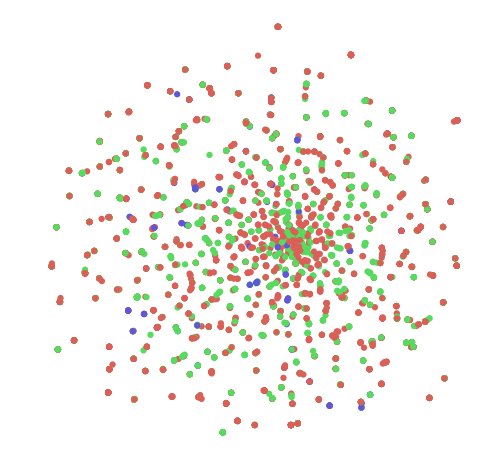

In [35]:
char_convert_num = dict(enumerate(characters_to_analyze))
char_convert_num = {v: k for k, v in char_convert_num.items()}
y = np.array(map(lambda x: char_convert_num[x], char_tags))
scatter(scripts_proj, y);

# After Reduction k=160 TSNE (plotting high dimension into 2D)

In [18]:
T,sigma,D_trans = SVDS(x, k=160)
D = D_trans.T

precomputed_D = pairwise_distances(D, metric='cosine') + .0001
scripts_proj = TSNE(random_state=0, n_components=2, metric='precomputed').fit_transform(precomputed_D)

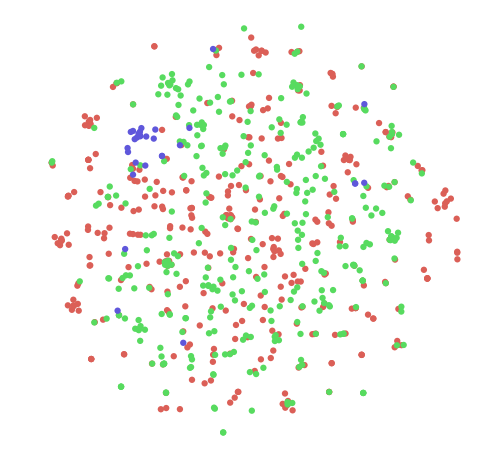

In [19]:
char_convert_num = dict(enumerate(characters_to_analyze))
char_convert_num = {v: k for k, v in char_convert_num.items()}
y = np.array(map(lambda x: char_convert_num[x], char_tags))
scatter(scripts_proj, y);

# After reduction k = 40

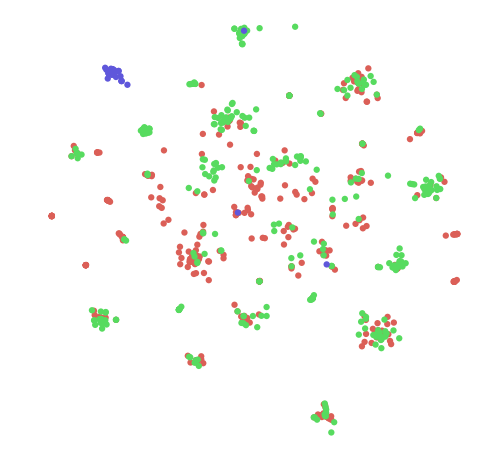

In [36]:
T,sigma,D_trans = SVDS(x, k=40)
D = D_trans.T

precomputed_D = pairwise_distances(D, metric='cosine') + .0001
scripts_proj = TSNE(random_state=0, n_components=2, metric='precomputed').fit_transform(precomputed_D)
char_convert_num = dict(enumerate(characters_to_analyze))
char_convert_num = {v: k for k, v in char_convert_num.items()}
y = np.array(map(lambda x: char_convert_num[x], char_tags))
scatter(scripts_proj, y);

# After reduction k = 10

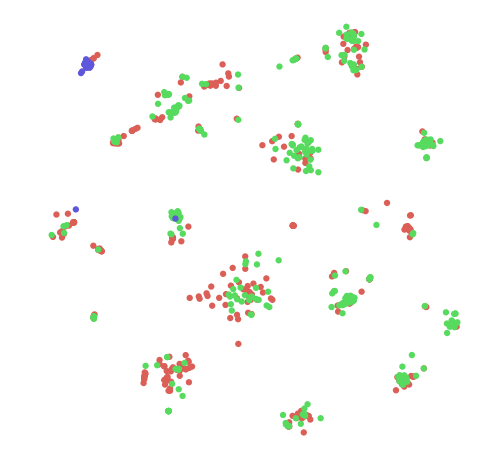

In [38]:
T,sigma,D_trans = SVDS(x, k=10)
D = D_trans.T

precomputed_D = pairwise_distances(D, metric='cosine') + .0001
scripts_proj = TSNE(random_state=0, n_components=2, metric='precomputed').fit_transform(precomputed_D)
char_convert_num = dict(enumerate(characters_to_analyze))
char_convert_num = {v: k for k, v in char_convert_num.items()}
y = np.array(map(lambda x: char_convert_num[x], char_tags))
scatter(scripts_proj, y);

##### Seems pretty clear that SVD is "creating clusters" for us.  

# Now let's cluster using Affinity Propagation

In [20]:
ac = AffinityPropagation(affinity='precomputed', damping=.5)
ac.fit_predict(precomputed_D)


clustered_characters = sorted(zip(ac.labels_, char_tags), key=lambda x: x[0])
clustered_characters_w_sentence = sorted(zip(ac.labels_, char_tags, sentence_list), key=lambda x: x[0])


In [21]:
metrics.silhouette_score(precomputed_D, ac.labels_, metric='precomputed')

-0.035047907897461608

# Let's look at a few example clusters

In [11]:
[x for x in clustered_characters_w_sentence if x[0] == 20]

NameError: name 'clustered_characters_w_sentence' is not defined

# Correlation Matrix

In [ ]:

character_groups = []
ch_uniquekeys = []

for i, label in groupby(clustered_characters, lambda x: x[0]):
    local_labels = [i[1] for i in label]
#     local_labels = Counter([i[1] for i in label])
    character_groups.append(local_labels)
    ch_uniquekeys.append(i)
    
    
character_doc_vectorizer = TfidfVectorizer(norm='l1')
ch_occurences = [" ".join(i) for i in character_groups]
ch_x = character_doc_vectorizer.fit_transform(ch_occurences)
ch_pairs = pairwise_distances(ch_x.T, metric='cosine') + .0001

pair_dist = pdist(ch_x.T.toarray())
v = squareform(pair_dist)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
labels = np.array(characters_to_analyze)
ax.matshow(v, cmap=plt.cm.gray)
ax.set_xticks(range(len(characters_to_analyze)))
ax.set_yticks(range(len(characters_to_analyze)))
ax.set_yticklabels(labels)
ax.set_xticklabels(labels);
;

Examples of clusters